<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/ERD_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERD/S

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from scipy.signal import butter, filtfilt, iirnotch, freqz, lfilter, cheby2


!pip3 install obci_readmanager --quiet 
from obci_readmanager.signal_processing.read_manager import ReadManager

!pip3 install -U https://api.github.com/repos/saffy-team/saffy/zipball/master
import saffy

from google.colab import drive

sns.set()
sns.set_context("talk", font_scale=1.4)

    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 6.2MB 3.2MB/s 
     / 778kB 76.3MB/s
    100% |████████████████████████████████| 6.2MB 4.0MB/s 
    100% |████████████████████████████████| 17.3MB 862kB/s 
    100% |████████████████████████████████| 10.1MB 2.6MB/s 
    100% |████████████████████████████████| 235kB 29.3MB/s 
    100% |████████████████████████████████| 24.8MB 893kB/s 
    100% |████████████████████████████████| 215kB 28.7MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-a5sd_wd_/wheels/8e/bb/f6/2df11782f77e288abdb4fffee0812e5d68a7734b92f3be9459
  Stored in directory: /root/.cache/pip/wheels/39/f9/f5/3e2fdef321f8e1f64061730c8ba2c81ad55c4b1b860b29d2dd
Successfully built saffy mne
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
google-colab 1.0.0 has requirement six~=1.11.0, but you'll have six 1.12.0 which is incompatible.
datascience 0

In [0]:
drive.mount('/content/gdrive')
# data_path = '/content/gdrive/My Drive/pracowniaEEG/ERD S/dane'
data_path = '/content/gdrive/My Drive/Uczelnia/ERD S_2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Utility Functions

In [0]:
def sin(t, f):
  return np.sin(2 * np.pi * f * t)

def noise(t, loc=0, scale=1):
  return np.random.normal(loc=loc, scale=scale, size=len(t))

In [0]:
def generate_signal():
  data = {
      'fs': 512,
      'num_channels': 3,
      'channel_names': ['C3', 'C4', 'd1'],
      'epochs': 1
  }
  
  T = 20
  t = np.arange(0, T, 1 / data['fs'])
  
  mu_freq = 10
  beta_freq = 23
  net_freq = 50
  
  data['data'] = np.zeros((data['epochs'], data['num_channels'], len(t)))
  
  for epoch in range(data['epochs']):
    data['data'][epoch][0] += (0.1 * t + 0.1) * sin(t, mu_freq)
    data['data'][epoch][0] += (0.1 * t**2 + 0.1) * sin(t, beta_freq)
    data['data'][epoch][0] += sin(t, net_freq)
    data['data'][epoch][0] += 0.3 * noise(t)

    data['data'][epoch][1] += (0.1 * t + 0.1) * sin(t, mu_freq)
    data['data'][epoch][1] += (0.1 * t + 0.1) * sin(t, beta_freq)
    data['data'][epoch][1] += sin(t, net_freq)
    data['data'][epoch][1] += 0.3 * noise(t)

    data['data'][epoch][2][::5*data['fs']] = 1
    data['data'][epoch][2][0] = 0
    
  data['t'] = t
  data['tags'] = []
  
  return data

## Wyznaczanie pasma $\mu$ i $\beta$.

In [0]:
# RAW_EEG = saffy.SignalManager(filename=f"{data_path}/ola_erds_2")
RAW_EEG = saffy.SignalManager(filename=f"{data_path}Copy of maks")

2019-04-09 11:02:40,092 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [0]:
def find_beta_mu_procedure(EEG):
  EEG.butter_highpass_filter(1, 2)
  EEG.cheb2_notch_filter(50, order=1, rs=3, width=0.3, btype='bandstop')

  PRE_EEG = EEG.copy('pre')
  PRE_EEG.set_epochs_from_tags(-4, -2)

  PRE_EEG.welch_mean_spectrum()

  POST_EEG = EEG.copy('post')
  POST_EEG.set_epochs_from_tags(0.5, 2.5)

  POST_EEG.welch_mean_spectrum()

  fig, ax = plt.subplots(
      nrows=max([PRE_EEG.num_channels, POST_EEG.num_channels]),
      ncols=1,
      sharex=True,
      sharey=True,
      figsize=(10, 10)
  )

  PRE_EEG.graphics_time_plot(
      fig,
      ax,
      'Przebieg Czasowy Sygnału',
      label='Przed Zdarzeniem',
      xlabel='Czas [s]',
      ylabel='Amplituda [$\mu$V]',
      alpha=0.1
  ),
  POST_EEG.graphics_time_plot(
      fig,
      ax,
      label='Po Zdarzeniu',
      alpha=0.1,
      color='blue'
  )

  plt.show()
  plt.close()

  fig, ax = plt.subplots(
      nrows=max([PRE_EEG.num_channels, POST_EEG.num_channels]),
      ncols=1,
      sharex=True,
      sharey=True,
      figsize=(10, 10)
  )

  PRE_EEG.graphics_spectrum_plot(
      fig,
      ax,
      'Gęstość Widmowa Mocy',
      label='Przed Zdarzeniem',
      xlabel='Częstotliwość [Hz]',
      ylabel='Moc [log($\mu$V)]'
  )

  POST_EEG.graphics_spectrum_plot(
      fig,
      ax,
      color='#0000ff',
      label='Po Zdarzeniu'
  )

  for a in ax:
    a.axvline(10, color='#ff0641', ls='--')
    
  for a in ax:
    a.axvline(19, color='#ff0641', ls='--')

  plt.yscale('log')
  plt.show()
  plt.close()


In [0]:
def ear_montage(self, ear_channels=['TP9', 'TP10']):
  assert len(ear_channels) == 2
  
  ear_idx = [
      self.channel_names.index(ear_channel)
      for ear_channel in ear_channels
  ]
  
  self.data = self.data - self.data[:, ear_idx, :].mean(axis=1)


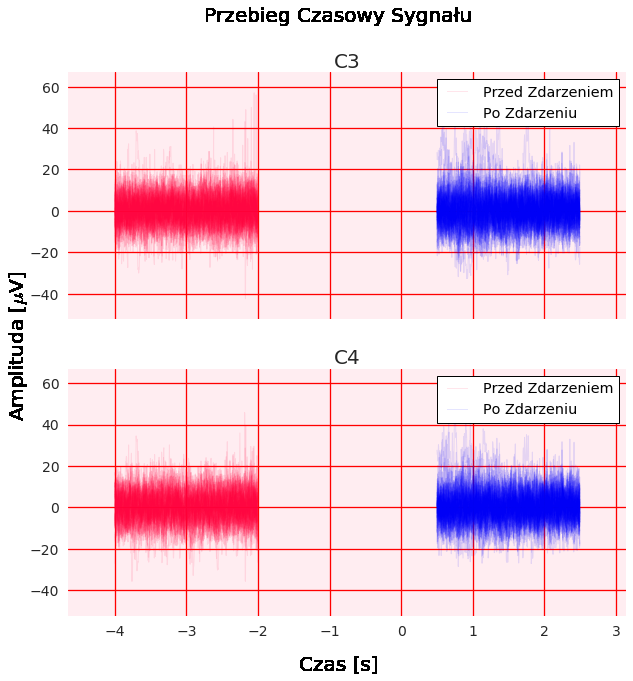

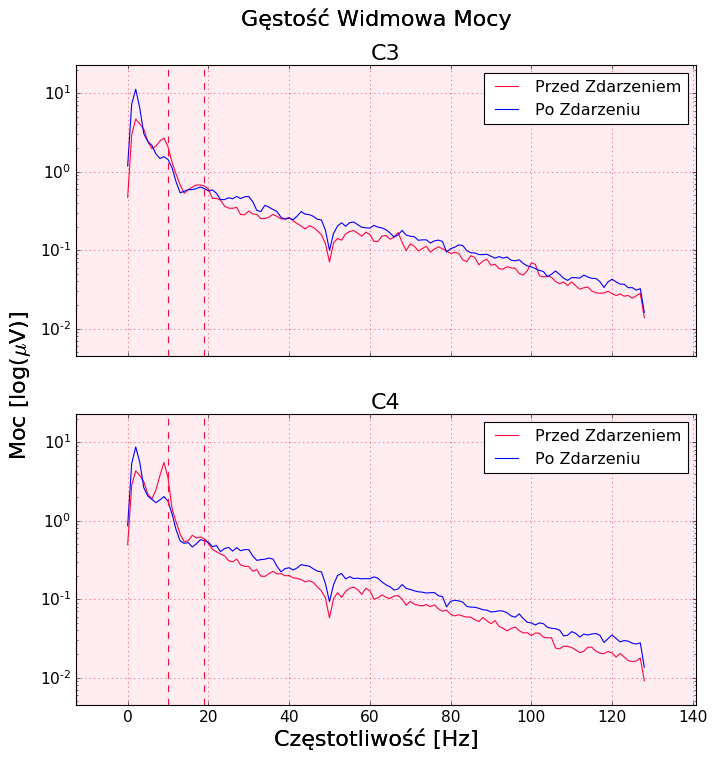

In [0]:
EEG = RAW_EEG.copy('eeg')

EEG.set_tags_from_channel('trig')

# EEG.remove_channels(['trig'])

EEG.call(ear_montage)

EEG.extract_channels(['C3', 'C4'])

find_beta_mu_procedure(EEG)

## Wyznaczenie przebiegu czasowego ERD i ERS

Zaprojektuj filtry pasmowo przepustowe (Chebyszewa 2 rodzaju) zgodne z wyznaczonymi pasmami.

Zbadaj funkcje przenoszenia i odpowiedzi impulsowej.

Powycinaj sygnały od −5 do +5 sekund (wszystkie kanały). Przefiltruj każdą realizację.

Oblicz moc chwilową za pomocą transformaty Hilberta (kwadrat amplitudy chwilowej).

Uśrednij moc chwilową po realizacjach.

Oblicz względną zmianę mocy chwilowej względem czasu −4 do −2. W ten sposób otrzymasz przebieg ERD i ERS w czasie.

Wykreśl ERD i ERS w układzie topograficznym. (Rozmieść subploty tak, aby z w przybliżeniu odpowiadały pozycjom elektrod).

In [0]:
def time_erds_procedure(EEG, mu_freq = 10, beta_freq = 19):
  EEG.butter_highpass_filter(cutoff=1, order=2)
  EEG.cheb2_notch_filter(cutoff=50, order=1, rs=3, width=0.3, btype='bandstop')

  MU_EEG = EEG.copy('mu')
  BETA_EEG = EEG.copy('beta')

#   MU_EEG.cheb2_notch_filter(mu_freq, order=1, rs=3, width=0.3, btype='bandpass')
  MU_EEG.cheb2_notch_filter(mu_freq, order=1, rs=3, width=0.3, btype='bandpass')
#   BETA_EEG.cheb2_notch_filter(beta_freq, order=1, rs=5, width=0.3, btype='bandpass')
  BETA_EEG.cheb2_notch_filter(29.5, order=1, rs=20, width=6.5, btype='bandpass')

  MU_EEG.set_epochs_from_tags(-5, 5)
  BETA_EEG.set_epochs_from_tags(-5, 5)

  fig, ax = plt.subplots(
      nrows=max([MU_EEG.num_channels, BETA_EEG.num_channels]),
      ncols=1,
      sharex=True,
      sharey=True,
      figsize=(10, 10)
  )

  MU_EEG.graphics_time_plot(
      fig,
      ax,
      'Przebieg Czasowy Sygnału dla Pasm',
      alpha=0.3,
      label='mu',
      xlabel='Czas [s]',
      ylabel='Amplituda [$\mu$V]'
  )

  BETA_EEG.graphics_time_plot(
      fig,
      ax,
      '',
      color='#0000ff',
      alpha=0.3,
      label='beta'
  )

  plt.show()
  plt.close()
  
  MU_EEG.hilbert_transform(phase_freq=mu_freq)
  MU_EEG.hilbert_mean_power()

  BETA_EEG.hilbert_transform(phase_freq=beta_freq)
  BETA_EEG.hilbert_mean_power()
  
  MU_EEG.epochs = 1
  BETA_EEG.epochs = 1

  MU_EEG.hilbert_subtract_base(-4, -2)
  BETA_EEG.hilbert_subtract_base(-4, -2)

  low, high = -2, 4
  low_samp = np.where(MU_EEG.t == low)[0][0]
  high_samp = np.where(MU_EEG.t == high)[0][0]

  MU_EEG.extract_time_range(low, high)
  BETA_EEG.extract_time_range(low, high)

  MU_EEG.hilbert['power'] = MU_EEG.hilbert['power'][:, :, low_samp: high_samp]
  BETA_EEG.hilbert['power'] = BETA_EEG.hilbert['power'][:, :, low_samp: high_samp]
  
  plt.style.use('classic')
  
  fig, ax = plt.subplots(
      nrows=max([MU_EEG.num_channels, BETA_EEG.num_channels]),
      ncols=1,
      sharex=True,
      sharey=True,
      figsize=(10, 10)
  )


  for channel in range(BETA_EEG.num_channels):
    ax[channel].plot(
        MU_EEG.t,
        MU_EEG.hilbert['power'][0, channel, :],
        color='#ff0641',
        label='mu'
    )
    ax[channel].plot(
        BETA_EEG.t,
        BETA_EEG.hilbert['power'][0, channel, :],
        color='blue',
        label='beta'
    )
    
    ax[channel].axvline(
						0,
						color='#ff0641',
						ls='--'
					)

    ax[channel].margins(0.1, 0.1)

    ax[channel].set_title(
      BETA_EEG.channel_names[channel],
      fontsize=20
    )
    ax[channel].set_facecolor('#ffedf1')
    ax[channel].tick_params(labelsize=14)
    ax[channel].grid(True, color='r')
    ax[channel].legend()

    fig.text(
      0.5,
      0.05,
      'Czas [s]',
      ha='center',
      fontsize=20
    )
    fig.text(
      0.5,
      0.95,
      'Przebieg czasowy ERD/S',
      ha='center',
      fontsize=20
    )
    fig.text(
      0.04,
      0.5,
      'Wartość ERD/S',
      va='center',
      rotation='vertical',
      fontsize=20
    )

    fig.patch.set_facecolor('#ffffff')

  plt.show()
  plt.close()

2019-04-09 11:25:02,451 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


['O1', 'O2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'TP9', 'TP10', 'T7', 'C3', 'Cz', 'C4', 'T8', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2', 'Saw', 'trig']


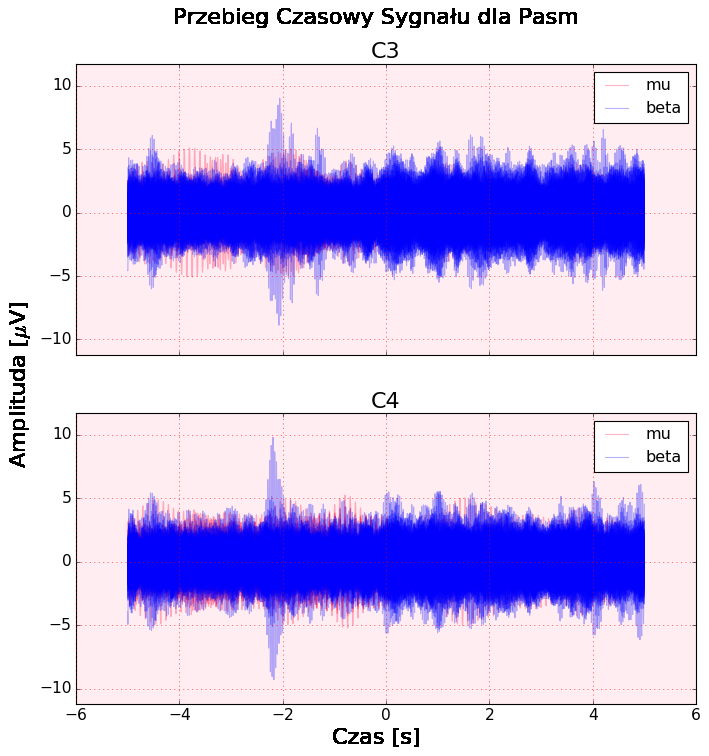

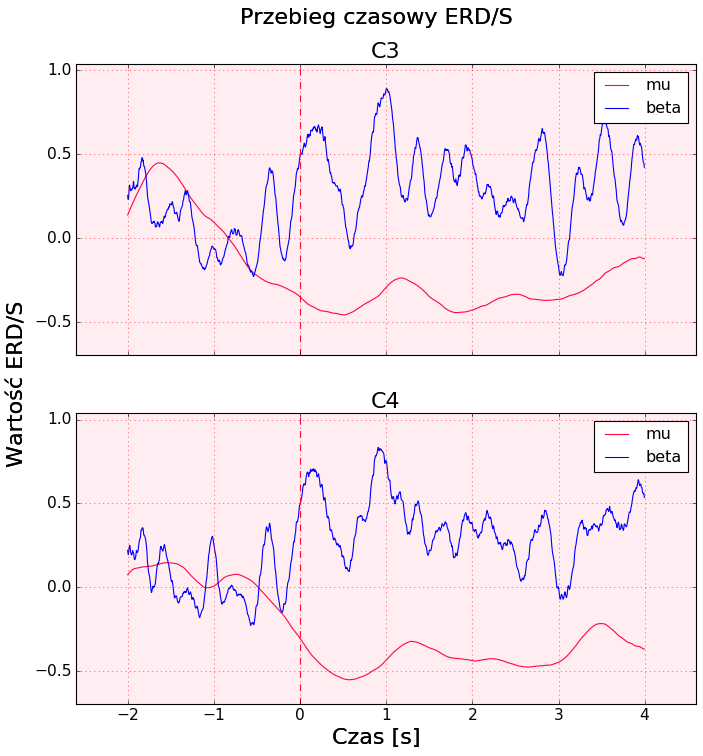

In [0]:
# RAW_EEG = saffy.SignalManager(filename=f"{data_path}Copy of maks")

EEG = RAW_EEG.copy('eeg')

# print(EEG.channel_names)

EEG.set_tags_from_channel('trig')

# EEG.remove_channels(['trig', 'Saw'])

# EEG.extract_channels(['C3', 'C4'])

EEG.call(ear_montage)

EEG.extract_channels(['C3', 'C4'])

time_erds_procedure(EEG, mu_freq=10, beta_freq=18)

### Hjort

In [0]:
class HjortPlugin(saffy.PluginManager):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    
    self.hjort = {}

  def hjort_transform(self, channel_name, channel_names):
    assert len(channel_names) == 4

    channel_index = self.channel_names.index(channel_name)
    channel_indexes = [self.channel_names.index(cn) for cn in channel_names]
    
    self.hjort[channel_name] = self.data[:, channel_index, :] - 1/4 * np.sum(self.data[:, channel_indexes, :], axis=1)
    
  def hjort_apply(self):
    for channel_name in self.hjort.keys():
      channel_index = self.channel_names.index(channel_name)
      self.data[:, channel_index, :] = self.hjort[channel_name]
    
    self.hjort = {}

saffy.SignalManager.register_plugin(HjortPlugin)

2019-04-09 07:27:03,820 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


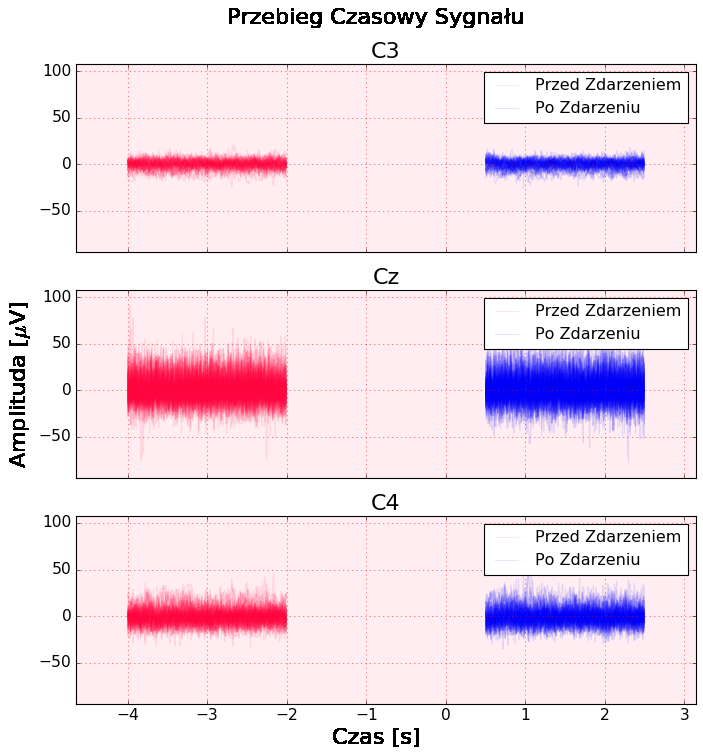

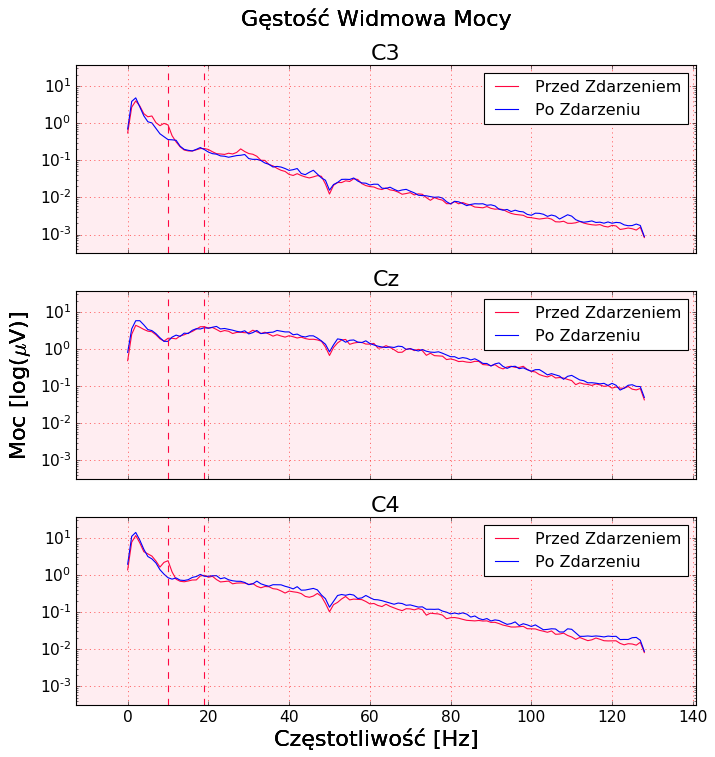

In [0]:
RAW_EEG = saffy.SignalManager(filename=f"{data_path}/ola_erds_2")

EEG = RAW_EEG.copy('eeg')

EEG.set_tags_from_channel('trig')

EEG.call(ear_montage)

EEG.extract_channels(['C3', 'C4', 'T7', 'P3', 'Cz', 'F3', 'T8', 'P4', 'F4', 'Fz', 'Pz'])

EEG.hjort_transform('C3', ['T7', 'P3', 'Cz', 'F3'])
EEG.hjort_transform('C4', ['T8', 'P4', 'Cz', 'F4'])
EEG.hjort_transform('Cz', ['Fz', 'C4', 'Pz', 'C3'])

EEG.hjort_apply()

EEG.extract_channels(['C3', 'C4', 'Cz'])

# EEG.remove_channels(['trig'])

find_beta_mu_procedure(EEG)

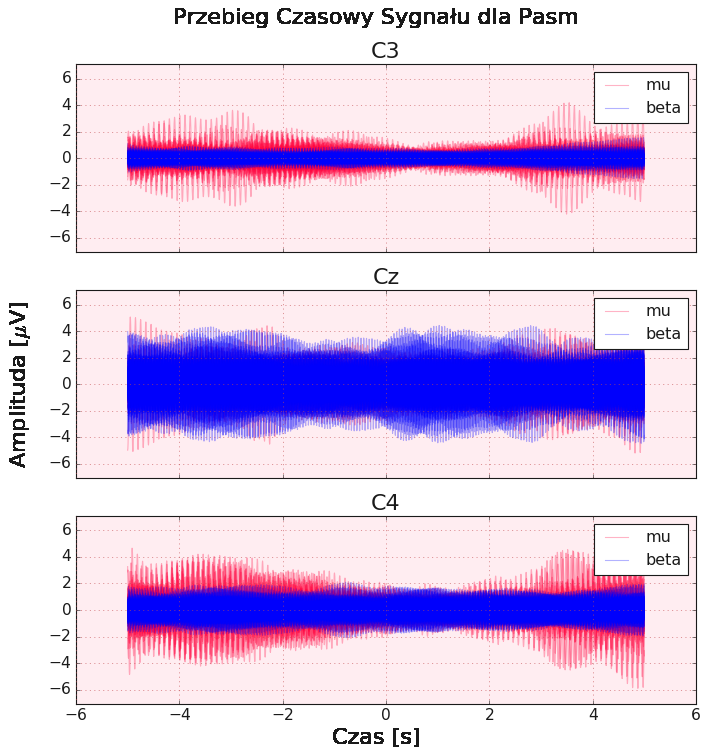

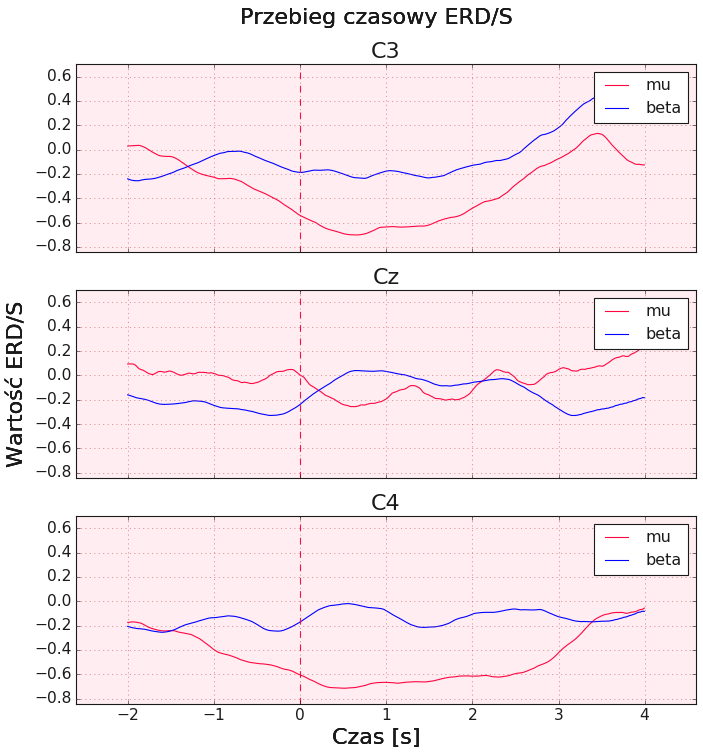

In [0]:
EEG = RAW_EEG.copy('eeg')

EEG.set_tags_from_channel('trig')

EEG.call(ear_montage)

EEG.extract_channels(['C3', 'C4', 'T7', 'P3', 'Cz', 'F3', 'T8', 'P4', 'F4', 'Fz', 'Pz'])

EEG.hjort_transform('C3', ['T7', 'P3', 'Cz', 'F3'])
EEG.hjort_transform('C4', ['T8', 'P4', 'Cz', 'F4'])
EEG.hjort_transform('Cz', ['Fz', 'C4', 'Pz', 'C3'])

EEG.hjort_apply()

EEG.extract_channels(['C3', 'C4', 'Cz'])

# EEG.remove_channels(['trig'])

time_erds_procedure(EEG, mu_freq=10, beta_freq=19)
